### Attention of Softmax(IMDB)

In [1]:
import pandas as pd
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
import torch
import pickle
from torch import optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
filename = 'data/local_dict.pkl'
path = filename
dict_file = open(path, 'rb')

vocab  = pickle.load(dict_file)[0]
print('length of vocabulary: ',len(vocab))
dict_file.close()

filename = "data/Train.csv"
Train = pd.read_csv(filename)

length of vocabulary:  16174


In [3]:
vocab_size = 8000
text_length = 30
batch_size = 100
epoch_num = 100

word2idx = {'[PAD]':0}
for i, w in enumerate(vocab[:vocab_size]):
    word2idx[w] = i + 1
idx2word = {i: w for i, w in enumerate(word2idx)}

doc_list = Train['text'].to_list()
labels = Train['label'].astype('int').to_list()

In [4]:
from model import make_data
data = make_data(doc_list,word2idx,text_length)

In [5]:
len(data),len(labels)

(40000, 40000)

In [6]:
from model import MyDataSet

batch = Variable(torch.LongTensor(data))
labels = Variable(torch.LongTensor(labels))
loader = Data.DataLoader(MyDataSet(batch,labels), batch_size, True)

In [7]:
from model import SelfAttnClassifier

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

loss_function = nn.BCELoss()
model = SelfAttnClassifier(vocab_size+1, 200, 100, 1, scale=5.0,score_function='dot',activation='SoftMax')
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.05)

use_gpu = torch.cuda.is_available()

if(use_gpu):
    model = model.cuda()
    loss_function = loss_function.cuda()

In [8]:
model.train()
for epoch in tqdm(range(100)):
    for input_ids, label in loader:
        model.zero_grad()
        preds = model(input_ids.cuda())
        loss = loss_function(preds.squeeze(), label.cuda().float()) * 100
        loss.backward(retain_graph=True)
        optimizer.step()
        input_ids.cpu()
        label.cpu()

100%|██████████| 100/100 [06:49<00:00,  4.10s/it]


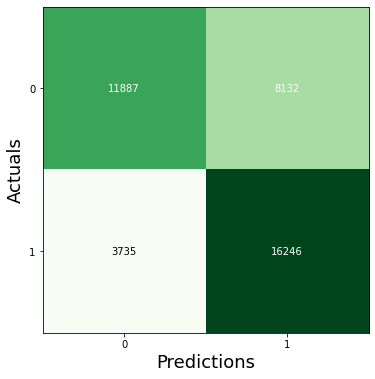

accuracy:70.332%


In [16]:
from model import plot_cm_matrix
plot_cm_matrix(model,batch,labels,save_url='graph/metric/SoftmaxTrainAcc.png')

### test accuracy

In [17]:
filename = "data/Test.csv"
Test = pd.read_csv(filename)

doc_list = Test['text'].to_list()
test_labels = Test['label'].astype('int').to_list()
    
test_data = make_data(doc_list,word2idx,text_length)
len(test_data),len(test_labels)

(5000, 5000)

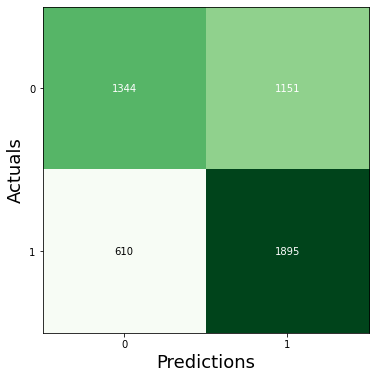

accuracy:64.780%


In [18]:
test_batch = Variable(torch.LongTensor(test_data))
test_labels = Variable(torch.LongTensor(test_labels))
plot_cm_matrix(model,test_batch,test_labels,save_url='graph/metric/picture3.png')

### Save Model

In [19]:
## 保存
torch.save(model.state_dict(), 'model/SoftmaxParameter.pkl')
torch.save(model, 'model/SoftmaxModel.pkl')

## 加载
#model = SelfAttnClassifier(vocab_size+1, 30, 10, 1, scale=5.0,score_function='dot',activation='SoftMax')
#model.load_state_dict(torch.load('model/SoftmaxParameter.pkl'))

# 加载
#model = torch.load('model/SoftmaxModel.pkl')

### Select Tokens

In [13]:
from model import SelectTokens
Pos,Neg,Neu = SelectTokens(data,labels,word2idx)

### Visualization

In [14]:
from model import compute_coefficients
pos_index,pos_score,pos_weight,neg_index,neg_score,neg_weight,neutral_index,neutral_score,neutral_weight = compute_coefficients(model,batch,Pos,Neg,Neu,word2idx)

Pos Mean: -0.2059527510767677 Pos Std: 0.3403278900142366
Neg Mean: -0.11153430119356567 Neg Std: 0.32777028316120765
Neu Mean: -2.171522434518387 Neu Std: 1.3513591957076967


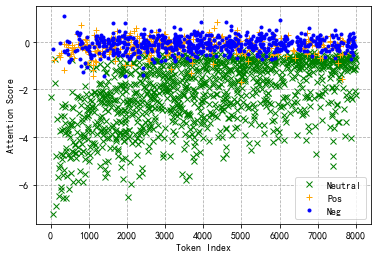

In [17]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index, neutral_score, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_score, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_score, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Score')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture1.png')
print('Pos Mean:',np.mean(pos_score),'Pos Std:',np.std(pos_score))
print('Neg Mean:',np.mean(neg_score),'Neg Std:',np.std(neg_score))
print('Neu Mean:',np.mean(neutral_score),'Neu Std:',np.std(neutral_score))

Pos Mean: 0.20945796159299024 Pos Std: 0.047550533802786996
Neg Mean: 0.21745741890047532 Neg Std: 0.052139988793580117
Neu Mean: 0.08778216442817688 Neu Std: 0.09498062002230079


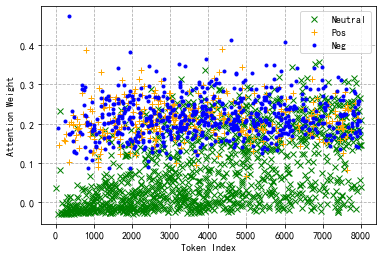

In [20]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index, neutral_weight, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_weight, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_weight, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture2.png')
print('Pos Mean:',np.mean(pos_weight),'Pos Std:',np.std(pos_weight))
print('Neg Mean:',np.mean(neg_weight),'Neg Std:',np.std(neg_weight))
print('Neu Mean:',np.mean(neutral_weight),'Neu Std:',np.std(neutral_weight))

### Exp1--Feature Importance

5000it [00:11, 450.47it/s]


Both label
	p-value < 0.05: 1889  ratio: 0.3778
	p-value < 0.01: 952  ratio: 0.1904
	Both-Mean: -0.21061482299955647 Std: 0.14439131665936003

Pos
	p-value < 0.05: 1181  ratio: 0.47145708582834334
	p-value < 0.01: 656  ratio: 0.26187624750499
	Pos-Mean: -0.24505990921336773 Std: 0.14095763588771867

Neg
	p-value < 0.05: 708  ratio: 0.2837675350701403
	p-value < 0.01: 296  ratio: 0.1186372745490982
	Neg-Mean: -0.17603168032797434 Std: 0.13944663313689018


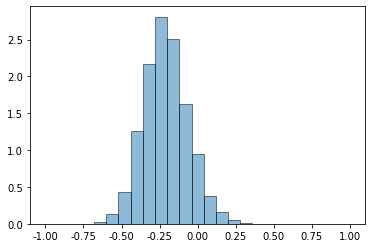

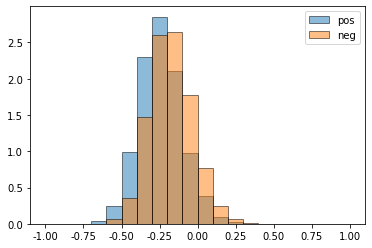

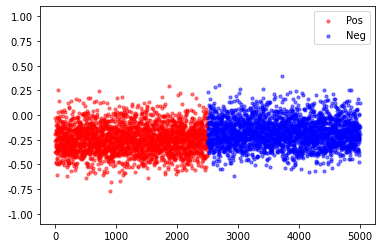

In [24]:
from model import GradientImportance
GradientImportance(model,test_batch,test_labels,'Softmax')

### Exp2--Feature Erasure

5000it [01:09, 71.56it/s]


Both label
	p-value < 0.05: 3939  ratio: 0.7878
	p-value < 0.01: 2792  ratio: 0.5584
	total num: 5000  mean: -0.349000491246082  std: 0.1213422772104017
Pos
	p-value < 0.05: 2048  ratio: 0.817564870259481
	p-value < 0.01: 1505  ratio: 0.6007984031936128
	total num: 2505  mean: -0.3606925967408613  std: 0.11774056749518798
Neg
	p-value < 0.05: 1891  ratio: 0.7579158316633267
	p-value < 0.01: 1287  ratio: 0.5158316633266533
	total num: 2495  mean: -0.33726152360503114  std: 0.1237475250842046


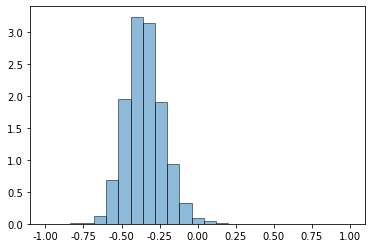

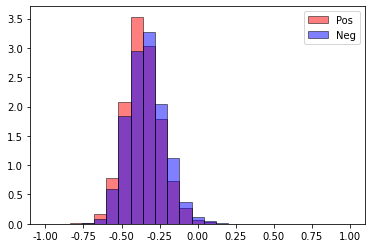

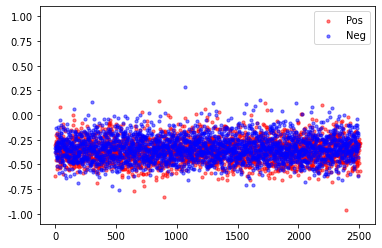

In [25]:
from model import FeatureErasure
FeatureErasure(model,test_batch,test_labels,'Softmax')

### Exp3--Feature Erasure ABS

5000it [01:13, 68.32it/s]


Both label
	p-value < 0.05: 535  ratio: 0.107
	p-value < 0.01: 146  ratio: 0.0292
	total num: 5000  mean: -0.06546990098947084  std: 0.14594786461715287
Pos
	p-value < 0.05: 364  ratio: 0.14530938123752496
	p-value < 0.01: 101  ratio: 0.04031936127744511
	total num: 2505  mean: -0.1052167164300109  std: 0.1410809505097589
Neg
	p-value < 0.05: 171  ratio: 0.06853707414829659
	p-value < 0.01: 45  ratio: 0.018036072144288578
	total num: 2495  mean: -0.025563779675421595  std: 0.1397307517872801


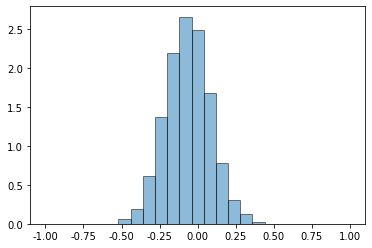

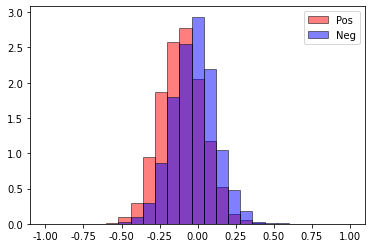

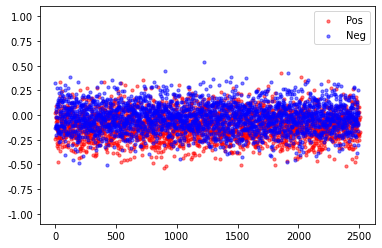

In [26]:
from model import FeatureErasureABS
FeatureErasureABS(model,test_batch,test_labels,'Softmax')

### Exp4--Attention Permutation

5000it [04:07, 20.20it/s]


Both label
	total num: 5000  mean: 0.13577387  std: 0.107226565
Pos
	total num: 2505  mean: 0.12513131  std: 0.09545106
Neg
	total num: 2495  mean: 0.14645906  std: 0.116900995


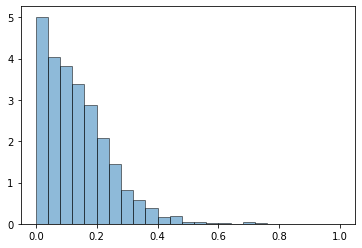

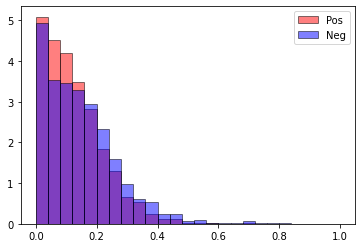

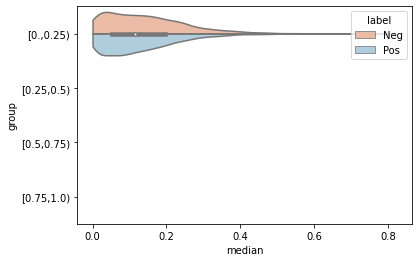

                 median                                                        \
                  count      mean       std           min       25%       50%   
label group                                                                     
Neg   [0.,0.25)  2495.0  0.146459  0.116924  1.181608e-07  0.055046  0.126716   
Pos   [0.,0.25)  2505.0  0.125131  0.095470  2.467632e-05  0.050710  0.106439   

                                     
                      75%       max  
label group                          
Neg   [0.,0.25)  0.212179  0.823166  
Pos   [0.,0.25)  0.179614  0.703835  


In [27]:
from model import AttnPermutation
AttnPermutation(model,test_batch,test_labels,'Softmax')

### Exp5--Attention Randomization

5000it [03:20, 24.94it/s]


Both label
	total num: 5000  mean: 0.24978875  std: 0.20229788
Pos
	total num: 2505  mean: 0.24138752  std: 0.18373933
Neg
	total num: 2495  mean: 0.25822362  std: 0.21903294


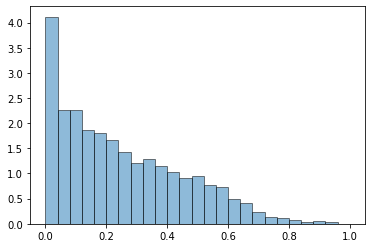

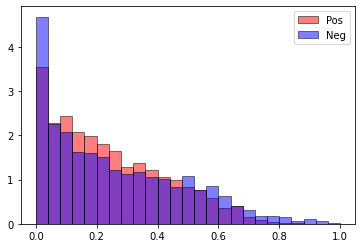

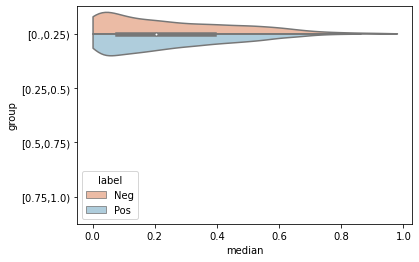

                 median                                                        \
                  count      mean       std           min       25%       50%   
label group                                                                     
Neg   [0.,0.25)  2495.0  0.258224  0.219077  2.265744e-08  0.069051  0.205292   
Pos   [0.,0.25)  2505.0  0.241388  0.183776  4.196167e-05  0.086759  0.204125   

                                     
                      75%       max  
label group                          
Neg   [0.,0.25)  0.414830  0.979199  
Pos   [0.,0.25)  0.367962  0.862276  


In [28]:
from model import AttnRandom
AttnRandom(model,test_batch,test_labels,'Softmax')

### check selected tokens

In [29]:
pos_df = pd.DataFrame(zip(pos_index,pos_score),columns=['index','value'])
pos_top_index = pos_df.sort_values(by='value',ascending=False)['index'].values[:50]
pos_top_words = []
for item in pos_top_index:
    pos_top_words.append(idx2word[item])
print(pos_top_words)
print(len(pos_df))

['refreshing', 'captures', 'dana', 'riveting', 'soccer', 'musicians', 'spell', 'scorpion', 'limitations', 'cleverly', 'wore', 'cerebral', 'offbeat', '26', 'lily', 'careful', 'endearing', 'diverse', 'masterfully', 'packs', 'holly', 'happily', 'bourne', 'forum', 'outstanding', 'pa', 'expose', 'wonderfully', 'pitch', 'essence', 'breath', 'jackass', 'ingenious', 'kline', 'september', 'clooney', 'atmospheric', 'weber', 'appreciated', 'melancholy', 'draws', 'awareness', 'grim', 'portrait', 'mick', 'goodfellas', 'dogma', 'troubled', 'secretary', 'aesthetic']
370


In [30]:
neg_df = pd.DataFrame(zip(neg_index,neg_score),columns=['index','value'])
neg_top_index = neg_df.sort_values(by='value',ascending=True)['index'].values[:50]
neg_top_words = []
for item in neg_top_index:
    neg_top_words.append(idx2word[item])
print(neg_top_words)
print(len(neg_df))

['bother', 'crap', 'save', 'total', 'steven', 'cheap', 'mediocre', 'money', 'intro', 'captivates', 'splitting', 'failed', 'absurd', 'reflective', 'promise', 'tried', 'continuity', 'attempt', 'blair', 'dumb', 'asleep', 'poor', 'weak', 'cliches', 'embedded', 'rambling', 'whiny', 'utter', 'christian', 'avoid', 'bore', 'elegantly', 'rehash', 'oh', 'shallow', 'zombie', 'lighting', 'sucked', 'suck', 'deftly', 'below', 'lit', 'confessions', 'unless', 'zero', 'infectious', 'malkovich', 'dollars', 'unlikeable', 'beer']
612


In [31]:
neu_df = pd.DataFrame(zip(neutral_index,neutral_score),columns=['index','value'])
neu_top_index1 = neu_df.sort_values(by='value',ascending=True)['index'].values[:50]
neu_top_index2 = neu_df.sort_values(by='value',ascending=False)['index'].values[:50]
neu_top_words = []
for item in neu_top_index1:
    neu_top_words.append(idx2word[item])
for item in neu_top_index2:
    neu_top_words.append(idx2word[item])
print(neu_top_words)
print(len(neu_df))

['characters', 'everything', 'acted', 'gets', 'nearly', 'character', 'away', 'next', 'others', '15', 'island', 'boy', 'laughed', 'truly', 'fans', 'beginning', 'ones', 'student', 'lots', 'consider', 'leading', 'exactly', 'christopher', 'coming', 'soon', 'prison', 'part', 'situation', 'sight', 'race', '2000', 'twenty', 'tired', 'probably', 'mixed', 'come', 'developed', 'note', 'writer', 'seeing', 'laughs', 'travel', 'animals', 'planet', 'wondered', 'limited', 'jennifer', 'account', 'fair', 'change', 'vast', 'contest', 'juice', 'advertised', 'quick', 'shape', 'enjoying', 'medical', 'instance', 'transition', 'coupled', 'extended', 'tepid', 'releasing', 'ivan', 'bumbling', 'peace', 'mtv', 'hack', 'doomed', 'israel', 'stallone', 'fewer', 'bent', 'approached', 'mythology', 'indication', 'represented', 'innuendo', 'budding', 'decidedly', 'frames', 'unbearable', 'martha', 'mamet', 'religion', 'schumacher', 'creepiest', 'roots', 'raunchy', 'pleasing', 'masses', 'appeals', 'lucas', 'figures', 'up